<a href="https://colab.research.google.com/github/pabloalima81/tcc1/blob/master/cfn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação de bibliotecas


In [148]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt


Define a versão do tensorflow

In [149]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.3.0'

In [150]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Pré-processamendo dos dados

Monta o Drive

In [151]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Nomeia as colunas

In [152]:
cols = ['label', 'preprocessed_news']

Carrega a base de dados

In [153]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cfn/Data/pre-processed.csv', header = None,
                         names = cols, engine = 'python', encoding = 'utf-8')
data.shape


(7200, 2)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


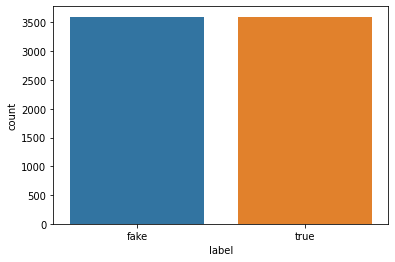

In [154]:
sns.countplot(data.label);

In [155]:
data.head()

,label,preprocessed_news
0,fake,katia abreu diz vai colocar expulsao moldura n...
1,fake,ray peita bolsonaro conservador fake entrevist...
2,fake,reinaldo azevedo desmascarado policia federal ...
3,fake,relatorio assustador bndes mostra dinheiro pub...
4,fake,radialista americano fala sobre pt vendem ilus...


In [156]:
data.tail()

,label,preprocessed_news
7195,true,jornal britanico acao contra lula lava jato se...
7196,true,temer diz acionou pf cade investigar aumentos ...
7197,true,obstaculos politicos temer especialistas ouvid...
7198,true,setembro boa noite aqui estao principais notic...
7199,true,envolvo politica diz brasileiro preso venezuel...


Coloca os previsores(noticias) em X

In [157]:
X = data.iloc[:, 1].values
X

array(['katia abreu diz vai colocar expulsao moldura nao reclamar senadora katia abreu disse expulsao pmdb resultado acao cupula atual legenda segundo oportunista amanha vou botar moldura dourada expulsao porque maos onde veio atestado boa conduta curriculo pessoas expulsaram nao servem pais servem pais beneficios proprios disse katia abreu ue expulsao algo tao bom curriculo tanta choradeira katia sabemos motivo provavelmente katia nao valor pt partido ja deveria absorvido parece pt gostava katia somente ficasse entrincheirada dentro pmdb rebaixar demais resta katia ficar chorando pitangas todos cantos tempo ate momento pt nao cadastrou katia abreu fileiras situacao patetica agricultura dilma',
       'ray peita bolsonaro conservador fake entrevista danilo gentili divide direita site vem avisando jair bolsonaro deveria abandonar pauta estatista vez fazer discurso convincente boa parte liberais conservadores brasil querem ver livres amarras estatais tudo bem pesquisas ainda dizem maior 

Coloca os classificadores(true or fake) em y

In [158]:
y = data.iloc[:, 0].values
y

array(['fake', 'fake', 'fake', ..., 'true', 'true', 'true'], dtype=object)

Separa a base em treino e teste. Stratify = y deixa um numero igual de registro para as dias classes

In [159]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.70, stratify = y)

In [160]:
X.shape

(2160,)

In [161]:
data.label.unique()

array(['fake', 'true'], dtype=object)

Verifica o numero de registros em cada classe

In [162]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array(['fake', 'true'], dtype=object), array([1080, 1080]))

Converte os valores das classes em zero e um

In [163]:
data_labels = y

In [164]:
data_labels[data_labels == 'true'] = 1
data_labels[data_labels == 'fake'] = 0
data_labels

array([0, 0, 0, ..., 0, 1, 1], dtype=object)

In [165]:
np.unique(data_labels)

array([0, 1], dtype=object)

# Tokenização

In [ ]:
import math
math.pow(2, 16)

65536.0

In [166]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(X, target_vocab_size=2**16)

In [167]:
tokenizer.vocab_size

48447

In [168]:
print (tokenizer.subwords)

['nao_', 'lula_', 'tambem_', 'sao_', 'ser_', 'disse_', 'presidente_', 'ja_', 'sobre_', 'anos_', 'federal_', 'ainda_', 'governo_', 'segundo_', 'brasil_', 'r_', 'ate_', 'temer_', 'pais_', 'ha_', 'ter_', 'diz_', 'contra_', 'vai_', 'pessoas_', 'dia_', 'ano_', 'pode_', 'ministro_', 'apos_', 'afirmou_', 'caso_', 'porque_', 'justica_', 'policia_', 'estado_', 'paulo_', 'acordo_', 'milhoes_', 'lava_', 'jato_', 'estao_', 'publico_', 'defesa_', 'dois_', 'so_', 'voce_', 'dilma_', 'fazer_', 'processo_', 'todos_', 'dinheiro_', 'ministerio_', 'mil_', 'hoje_', 'durante_', 'outros_', 'parte_', 'juiz_', 'odebrecht_', 'sera_', 'decisao_', 'casa_', 'operacao_', 'alem_', 'pt_', 'nesta_', 'prisao_', 'onde_', 'politica_', 'agora_', 'rio_', 'tribunal_', 'seguranca_', 'desde_', 'empresa_', 'coreia_', 'qualquer_', 'grande_', 'entao_', 'vez_', 'norte_', 'republica_', 'moro_', 'antes_', 'corrupcao_', 'trump_', 'camara_', 'grupo_', 'mundo_', 'apenas_', 'stf_', 'tudo_', 'dias_', 'tres_', 'momento_', 'forma_', 'lei_

In [169]:
data_inputs = [tokenizer.encode(sentence) for sentence in X]

In [170]:
for _ in range(20):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[59, 11, 635, 1641, 2591, 748, 192, 2, 1623, 1934, 53, 43, 11, 191, 3019, 795, 180, 69, 23609, 185, 9748, 2201, 1232, 381, 1455, 8066, 9439, 697, 1472, 44, 5245, 6747, 216, 2081, 999, 2468, 13125, 43000, 129, 7955, 2271, 584, 11, 990, 191, 3682, 1006, 653, 331, 50, 1276, 34, 14, 306, 40, 41, 73, 604, 11, 732, 996, 1598, 198, 2121, 607, 176, 255, 84, 297, 149, 1152, 318, 1097, 1001, 1097, 3363, 519, 696, 1538, 139, 787, 3076, 696, 1045, 8986, 2594, 1774, 2754, 10542, 1538, 139, 287, 791, 3653, 1152, 1097, 519, 59, 11, 635, 1975, 2400, 1641, 584, 11, 191, 2591, 748, 192, 2, 1364, 189, 9, 1276, 34, 956, 64, 40, 41, 47, 998, 32, 62, 14, 922, 15339, 120, 53, 43, 11, 932, 4, 1517, 29984, 23, 40, 41, 13837, 259, 369, 146, 2951, 1622, 62, 59, 134, 216, 2, 116, 381, 192, 2, 11913, 737, 4581, 279, 753, 21, 114, 2916, 104, 180, 401, 23685, 489, 1739, 3043, 248, 598, 149, 322, 5997, 5872, 25, 2030, 8996, 192, 9, 16775, 812, 14695, 1440, 1791, 7284, 482, 4453, 1203, 890, 3685, 78, 13580, 1051, 2040

# Padding
Preenche as sentenças deixando todas com mesmo tamanho

In [171]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

4229

In [172]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs, value = 0, padding = 'post', maxlen=max_len)

In [173]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[  44  249 1682 ...    0    0    0]
[6912  702  119 ...    0    0    0]
[628  18  20 ...   0   0   0]
[2004 9282  862 ...    0    0    0]
[151 329 569 ...   0   0   0]
[1067  101  568 ...    0    0    0]
[3845 9299 2312 ...    0    0    0]
[4106 2647 6074 ...    0    0    0]
[249 323 349 ...   0   0   0]
[586 418 282 ...   0   0   0]


# Divisao da Base de dados

In [174]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [175]:
train_inputs.shape

(1512, 4229)

In [176]:
train_labels.shape

(1512,)

In [177]:
test_inputs.shape

(648, 4229)

In [178]:
test_labels.shape

(648,)

# Model

In [179]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Treinamento

## Parâmetros

In [180]:
vocab_size = tokenizer.vocab_size
vocab_size

48447

In [181]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [182]:
dropout_rate = 0.2
nb_epochs = 5

## Treino

In [183]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [184]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Salva a rede treinada ou restaura última versão salva

In [185]:
checkpoint_path = "./content/drive/My Drive/Colab Notebooks/cfn"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [202]:
train_inputs=train_inputs.astype(np.int64)
train_labels=train_labels.astype(np.int64)

In [203]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/5
22/22 [==============================] - 154s 7s/step - loss: 0.6408 - accuracy: 0.6294 - val_loss: 0.5497 - val_accuracy: 0.9079
Epoch 2/5
22/22 [==============================] - 154s 7s/step - loss: 0.2751 - accuracy: 0.9640 - val_loss: 0.2276 - val_accuracy: 0.9211
Epoch 3/5
22/22 [==============================] - 155s 7s/step - loss: 0.0465 - accuracy: 0.9868 - val_loss: 0.1958 - val_accuracy: 0.9342
Epoch 4/5
22/22 [==============================] - 158s 7s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.2029 - val_accuracy: 0.9408
Epoch 5/5
22/22 [==============================] - 155s 7s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2231 - val_accuracy: 0.9408


'./content/drive/My Drive/Colab Notebooks/cfn/ckpt-1'